## <font color='blue'> ASTR 21100/31200</font>

## <font color='blue'> Homework Assignment 5</font>
    
 
## <font color='blue'> undergraduate students (50 points + 10 extra-credit)</font>
   
### <font color='blue'> Distributed: Friday, April 29</font>

### <font color='blue'> Due: Friday, May 6, 10pm</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM
import astropy.units as u
import scipy.interpolate
import scipy.optimize
from matplotlib.colors import LogNorm

# the following commands make plots look better
def plot_pretty(dpi=150,fontsize=15):
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in')
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5)
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5)
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    plt.rc('legend',fontsize=5)
    plt.rcParams['figure.figsize'] = [5, 5]

plot_pretty()


In [2]:
#zCMB, mB, emB are redshift of SNia, its apparent B-band magnitude, and emB is its error
# x1 and ex1 are stretch parameter measured for each SN and its uncertainty
# csn and ecsn are color parameter and its uncertainty
zCMB, mB, emB, x1, ex1, csn, ecsn = np.loadtxt('https://astro.uchicago.edu/~andrey/classes/a211/data/jla_lcparams.txt',
                                               usecols=(1, 4, 5, 6, 7, 8, 9), unpack=True)

print("read sample of %d supernovae..."%(np.size(zCMB)))

read sample of 740 supernovae...


### <font color='blue'>Exercise 1 (5 points): Constructing approximation for $d_L$</font>

Using the best approximation for $d_L$ that you identified in ex 1 of hw 4, construct a Python list of approximations for each of the 740 supernovae redshift. In other words, for each supernova in the sample above, construct approximation $\tilde{d}_L(\Omega_{\rm m0},\Omega_\Lambda)$ within the range $\Omega_{\rm m0}\in[0,1]$, $\Omega_{\Lambda}\in[0,1]$. Construct approximation and add object that computes $\tilde{d}_L(\Omega_{\rm m0},\Omega_\Lambda)$ for input values of $\Omega_{\rm m0}$ and $\Omega_\Lambda$. 


Namely, if the list is named <tt>dlz</tt>, you should be able to compute $d_L$ for a given supernova redshift $z_i$ and <tt>om</tt>, <tt>oml</tt> values as <tt>dlz[i](om, oml)</tt>. 

Test your list via direct calculations of $d_L$ using your own function or using AstroPy function. 

In [3]:
def d_l_tilde_astropy(z, H0, Om0, OmL, clight=2.99792e5):
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)

    return cosmo.luminosity_distance(z=z) / u.Mpc / (clight/H0)

def get_dl_train_test(ntrain=15, z=1.0, H0=70., clight=2.99792e5,
                      om0min=0., om0max = 1., omlmin=0., omlmax=1., spacing=np.linspace):

    om0tr = spacing(om0min, om0max, ntrain)
    omltr = spacing(omlmin, omlmax, ntrain)

    dl_train = np.zeros((ntrain, ntrain))
    for i, omd in enumerate(om0tr):
        for j, omld in enumerate(omltr):
                dl_train[i,j] = d_l_tilde_astropy(z, H0, omd, omld, clight = clight)

    return om0tr, omltr, dl_train

def train_model(ntrain=15, z=1.0, H0=70.,clight=2.99792e5,om0min=0., om0max = 1., omlmin=0., omlmax=1., s=0, kx=3, ky=3,spacing=np.linspace):
    om0tr, omltr, dl_train = get_dl_train_test(ntrain=ntrain, z=z, H0=H0, clight=clight, om0min=om0min, om0max=om0max, omlmin=omlmin, omlmax=omlmax, spacing=spacing)
    return scipy.interpolate.RectBivariateSpline(om0tr, omltr, dl_train, s=s, kx=kx, ky=ky)

### Constants

In [4]:
constants = {
"H0": 70.,
"clight": 2.99792e5
}

### Model Parameters:

In [5]:
parameters = {
"ntrain": 5,
"om0min": 0.,
"om0max": 1.,
"omlmin": 0.,
"omlmax": 1.,
"s": 0,
"kx": 3,
"ky": 3,
"spacing": np.linspace
}

In [6]:
print("Training Models")
dlz = {}
for idx,z in enumerate(zCMB):
    if idx % (len(zCMB)//10) == 0:
        if idx == 0:
            print("   ->   0% done...")
        else:
            print("   ->  " + str(round((idx/len(zCMB))*100)) + "% done...")
    dlz[z] = train_model(**parameters, **constants, z=z)
print("   -> 100% done...")

Training Models
   ->   0% done...
   ->  10% done...
   ->  20% done...
   ->  30% done...
   ->  40% done...
   ->  50% done...
   ->  60% done...
   ->  70% done...
   ->  80% done...
   ->  90% done...
   -> 100% done...


In [7]:
n_samples = 100
print("Testing the models using",n_samples,"random samples...")
sampled_frac_err = np.empty(n_samples,dtype=np.float64)
for i in range(n_samples):
    z = np.random.choice(zCMB)
    model = dlz[z]
    om0 = np.random.uniform()
    omL = np.random.uniform()
    model_val = model(om0,omL)
    direct_val = d_l_tilde_astropy(z,constants["H0"],om0,omL)
    sampled_frac_err[i] = np.abs(model_val/direct_val -1.)

print("Max Frac Err:",np.max(sampled_frac_err))
print("Min Frac Err:",np.min(sampled_frac_err))
print("Mean Frac Err:",np.mean(sampled_frac_err))

Testing the models using 100 random samples...
Max Frac Err: 0.00013798922812213732
Min Frac Err: 6.643574579356937e-12
Mean Frac Err: 5.551628189636171e-06


### <font color='blue'>Exercise 2 (10 points): Implementing likelihood and finding parameter values that maximizes likelihood of supernovae type Ia data given model parameters</font>

**Task 2a (5 points).** Implement a function to comput the likelihood using the expression:

$$\ln L(\mathbf{y}\vert\mathbf{x}) = -\frac{1}{2}\,\sum\limits_{i=0}^{N_{\rm SN}-1}\frac{\Delta\mu^2}{\sigma_{\Delta\mu,i}^2}-\frac{1}{2}\sum\limits_{i=0}^{N_{\rm SN}-1}\ln(2\pi\sigma_{\Delta\mu,i}^2)$$

and $\sigma_{\Delta\mu,i}^2$ is total uncertainty of the observational estimate of the distance modulus that accounts for uncertainties in $m_B$, $x_1$, and $c$, which by rules of error propagation is: 

$$\sigma_{\Delta\mu,i}^2 = \sigma_{m_B}^2 + \alpha^2\sigma_{x1}^2 + \beta^2\sigma_c^2,$$

which means that the error also depends on the two model parameters, $\alpha$ and $\beta$. 

The function should pass the supernova data and $d_L$ approximation via <tt>args</tt>. 

In [8]:
def loglikelihood(x, zCMB, mB, emB, x1, ex1, csn, ecsn, dlz, constants=constants):
    om0, omL, M0, a, b = x
    sig_mu_squared = emB**2 + (a**2) * (ex1**2) + (b**2) * (ecsn**2)
    dl = np.array([dlz[z](om0,omL) for z in zCMB]).flatten()
    mu = 5 * np.log10(dl) + 25
    mu_obs = mB - (M0 + 5*np.log10(constants["clight"]/constants["H0"]) + 25)
    del_mu_squared = (mu_obs - mu)**2
    first = del_mu_squared/sig_mu_squared
    second = np.log(2*np.pi*sig_mu_squared)
    return -0.5*np.sum(first) - 0.5*np.sum(second)

**Task 2b. (5 points)** Test your function by implementing a helper function that computes $-\ln L$ and find the values of 5 parameters $\mathbf{x}=\{\Omega_{\rm m0},\Omega_\Lambda, \tilde{M}_0, \alpha,\beta\}$ that minimize this function using the differential evolution function you implemented in hw 4, or <a href="https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.differential_evolution.html"><tt>scipy.minimize.differential_evolution</tt></a> function to find parameters that minimize $-\ln L$ and print them out. 

To define bounds, you can use ranges for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ of $[0,1]$ and for $\tilde{M}_0$ say $[20, 28]$. For $\alpha$ good choice for range is $[0.05, 0.3]$ and for $\beta$: $[1., 5.]$. Feel free to experiment with these ranges. 

### Differential Evolution Arguments

In [9]:
func_kwargs = {
"zCMB": zCMB,
"mB": mB,
"emB": emB,
"x1": x1,
"ex1": ex1,
"csn": csn,
"ecsn": ecsn,
"dlz": dlz,
"constants": constants
}
bounds = ((0,1),(0,1),(20,28),(0.05,0.3),(1,5))

kwargs = {
"popsize": 15,
"tol": 0.01,
"atol": 0
}

In [10]:
result = scipy.optimize.differential_evolution(loglikelihood,bounds,args=func_kwargs.values(),**kwargs)
print(result)
best_om0, best_omL, best_M0, best_a, best_b = result.x

     fun: -133668762.90723163
     jac: array([ 1536110.0435257 , -1366946.09432008, -3695493.63077218,
       99472312.61255792, 29972446.1469699 ])
 message: 'Optimization terminated successfully.'
    nfev: 1512
     nit: 19
 success: True
       x: array([ 0.  ,  1.  , 28.  ,  0.05,  1.  ])


### <font color='blue'>Exercise 3 (5 points): Using inverse transform </font>
    
to sample random numbers from the distribution $g(x)=A/\sqrt{x}$ for $x\in[1/a,a]$ where $a$ is a constant and $A$ is normalization constant.

**Task 3a (1 point).** Derive expression for the normalization constant $A$. 

$$
\begin{align}
\int_{\frac{1}{a}}^{a}g(x)\,\mathrm{d}x &= 1 \\
\int_{\frac{1}{a}}^{a}\frac{A}{\sqrt{x}}\,\mathrm{d}x &= 1 \\
A\int_{\frac{1}{a}}^{a}x^{-\frac{1}{2}}\,\mathrm{d}x &= 1 \\
A\left[ 2x^{\frac{1}{2}} \right]_{\frac{1}{a}}^a &= 1 \\
A(2\sqrt{a}-2\sqrt{\frac{1}{a}}) &= 1 \\
A &= \frac{1}{(2\sqrt{a}-2\sqrt{\frac{1}{a}})} \\
A &= \frac{1}{2(\sqrt{a}-\sqrt{\frac{1}{a}})} \\
\end{align}
$$

**Task 3b (1 point).** Derive the expression for the cdf $P(x)$ and its inverse $x = P^{-1}(y)$, where $y$ is value in the range $[0,1]$. 


$$
\begin{align}
P(x) &= \int_{\frac{1}{a}}^{x}g(x')\,\mathrm{d}x'\\
P(x) &= \int_{\frac{1}{a}}^{x}\frac{A}{\sqrt{x'}}\,\mathrm{d}x' \\
P(x) &= \int_{\frac{1}{a}}^{x}\frac{A}{\sqrt{x'}}\,\mathrm{d}x' \\
P(x) &= A(2\sqrt{x}-2\sqrt{\frac{1}{a}}) \\
P^{-1}(y) &= (\frac{y}{2A}+\sqrt{\frac{1}{a}})^{2} \\
\end{align}
$$

**Task 3c (3 points).** Assuming $a=2$ draw random numbers using inverse transform method using the inverse cdf you derive to draw $10^6$ sample tha follow pdf $g(x)$. Test your results by histogramming results and and comparing the histogram to the analytic expression for $g(x)$ shown as a line. 

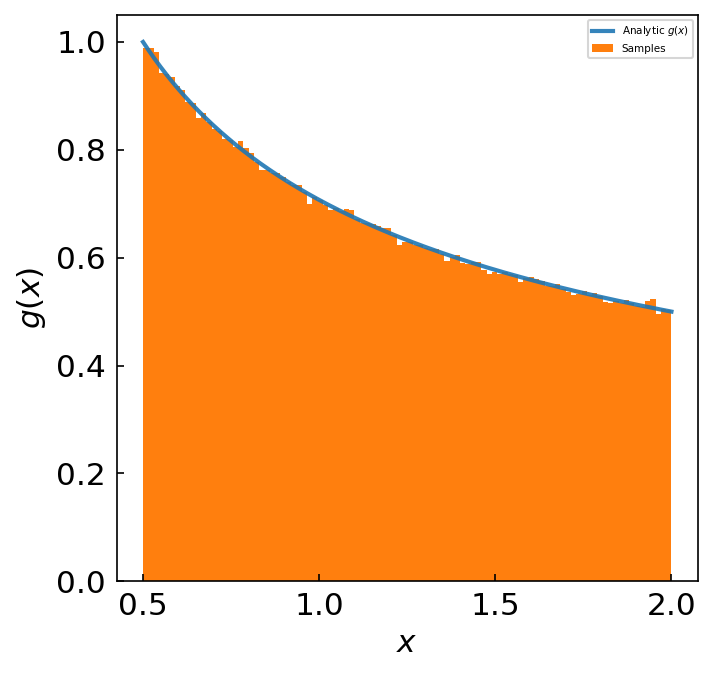

In [11]:
def g(x,a=2):
    A = 1/(2*(np.sqrt(a) - np.sqrt(1/a)))
    return A/np.sqrt(x)

def P(x,a=2):
    A = 1/(2*(np.sqrt(a) - np.sqrt(1/a)))
    return A*(2*np.sqrt(x) - 2*np.sqrt(1/a))

def P_inverse(y,a=2):
    A = 1/(2*(np.sqrt(a) - np.sqrt(1/a)))
    return ((y/(2*A)) + np.sqrt((1/a)))**2

a = 2
xs = np.linspace(1/a,a,1000)
nsamples = int(1e6)
samples = P_inverse(np.random.uniform(size=nsamples),a)

plt.plot(xs,g(xs,a),label="Analytic $g(x)$",zorder=1,linewidth=2,alpha=0.9)
plt.hist(samples,density=True,bins=100,label="Samples",zorder=0)
plt.xlabel("$x$")
plt.ylabel("$g(x)$")
plt.legend()
plt.show()

### <font color='blue'> Exercise 4: Implementing the affine-invariant MCMC algorithm of Goodman & Weare (2010) and using it to sample the likelihood (30 points + possible 10 extra-credit). </blue>
    
**Task 4a (20 points).**
Implement the "affine-invariant" MCMC algorithm proposed by <a href="http://msp.org/camcos/2010/5-1/p04.xhtml">Goodman & Weare (2010, hereafter GW10)</a> and described in <a href="https://drive.google.com/file/d/1h-0Be_HwXRdKOgdKSdtX0PiIe6-9Logg/view?usp=sharing"><tt>10_multid_sampling_mcmc</tt></a> notebook in the form of a Python function.

In [12]:
def lngauss_nd(x, means, icov):
    diff = x - means
    return -0.5 * np.dot(diff.T, np.dot(icov, diff))

def mcmc_gw10(x0, logpdf = None, args = None, nsteps = 10000):

    xnow = np.copy(x0)
    chain = []
    indexes = np.repeat(np.reshape(np.arange(len(xnow)),(1,len(xnow))),len(xnow),axis=0)

    mask = np.ones((len(xnow),len(xnow)),dtype=bool)
    np.fill_diagonal(mask,False)

    indexes = np.reshape(indexes.flatten()[mask.flatten()],(len(xnow),len(xnow)-1))

    for step in range(nsteps):

        indexes = indexes.T
        np.random.shuffle(indexes)
        indexes = indexes.T
        nextindexes = np.append(np.diagonal(indexes),np.random.randint(0,len(xnow)-1))
        xj = np.take(xnow,nextindexes,axis=0)

        zr = np.reshape(P_inverse(np.random.uniform(size=len(xnow)),2),(1,len(xnow))).T

        xprop = xj + (zr*(xnow-xj))

        #this is the fastest way to do this (vectorizing logpdf is implemented as a for loop as well)
        pi_xprop = np.exp(np.array([logpdf(j,*args) for j in xprop]))
        #this is the fastest way to do this (vectorizing logpdf is implemented as a for loop as well)
        pi_xnow = np.exp(np.array([logpdf(j,*args) for j in xnow]))

        zrd = P_inverse(np.random.uniform(size=len(xnow)),2) ** (xnow.shape[1]-1)

        pacc = np.clip(zrd*(pi_xprop/pi_xnow),0,1.0)

        rand_tests = np.random.uniform(size=len(pacc))

        accepted = rand_tests <= pacc

        temp = np.copy(xnow)
        xnow[accepted] = xprop[accepted]

        chain.append(np.copy(xnow))
    return np.stack(chain,axis=1)

#### <font color='darkblue'> Task 4b (3 points)</font>

Test your implementation of the GW 10 MCMC algorithm by sampling $\ln$ 2d Gaussian pdf using function <tt>lngauss_nd</tt> below. Plot resulting distributions of chain values for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ along with the confidence contours that correspond to $1-$ and $2-\sigma$ of the Gaussian distribution and enclose $0.6827$ and $0.9545$ of the total samples using example below using <tt>plot_2d_dist</tt> function from <tt>codes/plotting.py</tt>. 

In [13]:
means = np.array([0., 0.])
s1, s2, r = 1.0, 1.0, 0.95

cov = [[s1**2, r*s1*s2], [r*s1*s2, s2**2]]

icov = np.linalg.inv(cov)
args = [means, icov]

ndim = 2
nwalkers = 50
nsteps = 10000
p0 = np.zeros(((nwalkers, ndim)))
for d in range(ndim):
    p0[:,d] = 0.05*np.random.normal(size=nwalkers)

chain = mcmc_gw10(p0, logpdf=lngauss_nd, args=args, nsteps=nsteps)

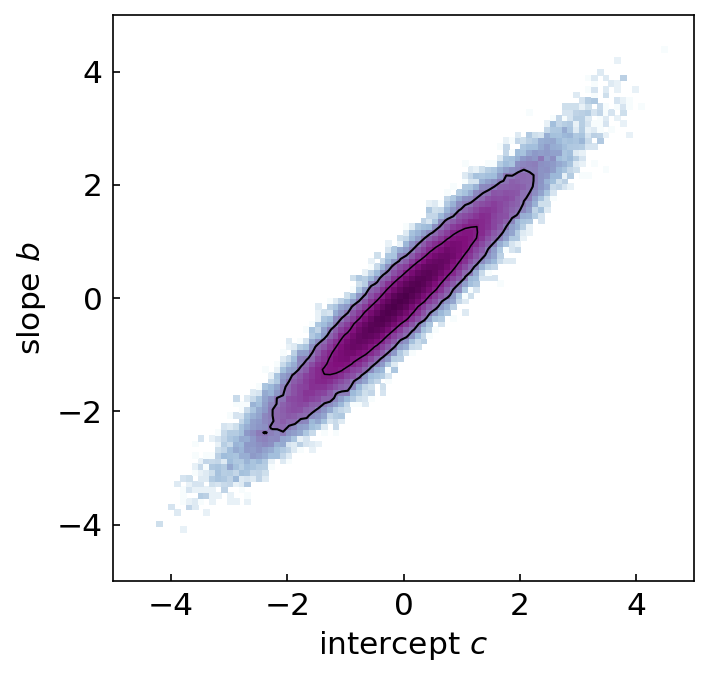

In [14]:
def plot_2d_dist(x,y, xlim, ylim, nxbins, nybins, figsize=(5,5), xlabel='x', ylabel='y',
                clevs=None):

    def conf_interval(x, pdf, conf_level):
        return np.sum(pdf[pdf > x])-conf_level

    fig, ax = plt.subplots(figsize=figsize)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

    if xlim[1] < 0.: ax.invert_xaxis()

    H, xbins, ybins = np.histogram2d(x, y, bins=(np.linspace(xlim[0], xlim[1], nxbins),np.linspace(ylim[0], ylim[1], nybins)))

    H = np.rot90(H); H = np.flipud(H);

    X,Y = np.meshgrid(xbins[:-1],ybins[:-1])

    H = H/np.sum(H)
    Hmask = np.ma.masked_where(H==0,H)

    pcol = ax.pcolormesh(X, Y,(Hmask),  cmap=plt.cm.BuPu, norm = LogNorm(), linewidth=0., rasterized=True, shading='auto')
    pcol.set_edgecolor('face')

    # plot contours if contour levels are specified in clevs
    if clevs is not None:
        lvls = []
        for cld in clevs:
            sig = scipy.optimize.brentq( conf_interval, 0., 1., args=(H,cld) )
            lvls.append(sig)

        ax.contour(X, Y, Hmask, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls),
                norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])

    plt.show()

conflevs = [0.6827, 0.9545]

x = chain[:,:,0].flatten()
y = chain[:,:,1].flatten()

plot_2d_dist(x, y, xlim=[-5, 5], ylim =[-5,5],
             nxbins=100, nybins=100,
             clevs=conflevs,
             xlabel=r'${\rm intercept}\ c$',
             ylabel=r'${\rm slope}\ b$', figsize=(5,5))

#### <font color='darkblue'> Task 4c (7 points)</font>

Write a function that defines natural logarithm of prior pdf for all parameters $\ln p$. Write another function that defines unnormalized posterior pdf, i.e. combines $\ln L$ (from ex 2 aove) and $\ln p$ into $\ln L(\mathbf{y}\vert\mathbf{x}) + \ln p(\mathbf{x})=\ln L(\mathbf{y}\vert\mathbf{x})p(\mathbf{x})$. For $p$ for all parameters you can assume uniform pdf defined between minimum and maximum value you choose for each parameter (these should be $0$ and $1$ for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ not to extrapolate your approximation for $\tilde{d}_L$. The total $\ln$ of prior pdf for all parameters is a sun of $\ln$ prior pdfs for individual parameters.

* Use your implementation of GW10 or <tt>emcee</tt> package to sample $\ln L(\mathbf{y}\vert\mathbf{x})p(\mathbf{x})$ using GW10 MCMC, initializing "walker" positions around the values of the best fit parameters you obtained in ex 2 above. 

* Plot resulting distributions of chain values for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ along with the confidence contours that correspond to $1-$ and $2-\sigma$ of the Gaussian distribution and enclose $0.6827$ and $0.9545$. 

* Use examples in [<tt>11_mcmc_stat_models</tt>](https://drive.google.com/file/d/1ksi7VjA48PutOS7TJ17FS5H2Ve0qmjv2/view?usp=sharing) notebook (for example, function <tt>chain_stats</tt> to output statistics about $\Omega_{\rm m0}$ and $\Omega_\Lambda$) to output statistics of these quantities.


In [15]:
x0 = result.x

bounds = ((0,1),(0,1),(20,28),(0.05,0.3),(1,5))

def prior(xd,bounds):
    for bound,i in zip(bounds,xd):
        print(bound,i)
        
        
print(prior(x0,bounds))

(0, 1) 0.0
(0, 1) 1.0
(20, 28) 28.0
(0.05, 0.3) 0.05
(1, 5) 1.0
None
